In [3]:
% reset
import settings
import tellurium as te; te.setDefaultPlottingEngine('matplotlib')
import cobra.util.solver as sutil
import os, re, cobra, pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
% matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# General routine

Inputs:
- run demarcate.py, to obtain a stoichiometic model of interest
- run flux.py, to obtain steady state flux solutions

Steps:
- load the stoichiometic model, and the flux data (ignore Delta_gibbs for now)
- extract the stoichiometric matrix
- remove Exchange reactions, these will not end up in the kinetic model. Other reactions and metabolites can also be removed, however this might affect the steady-state solution. It might therefore be favorable to remove a given compound from the model before running the FBA, such that we don't generate a imbalance. 
- now map the species and reactions to a generic name space. The current names can cause issues with some of the other software we are using (e.g. does not allow a metabolite name to start with a number). The flux solution needs to be mapped to the same name space.
- construct a kinetic model (string_model) given a standard rate law (e.g. Michaelis-Menten). This function should also generate the rewritten equation to calculate Vmax (a dependent parameter that will be calculated later)
- sample and set the parameters and initial conditions of the model (all but Vmax)
- calculate Vmax (as a part of the model: calculate this parameter)
- simulate the model. It should be in steady-state, if not, we need to figure out which metabolites are not in steady-state and fix them.
- finally we wish to simulate a perturbation, a switch in carbon source

Loading the stoichiometric model and flux data

In [4]:
extended_core = cobra.io.read_sbml_model(settings.ECOLI_EXCORE_FNAME)
flux_solution = pd.read_pickle(settings.CACHE_DIR+'/flux_solutions.p')

Extracting the stiochiometric matrix

In [5]:
def extract_stoich(model):
    model_array = model.to_array_based_model()
    S = pd.DataFrame(data = model_array.S.todense(), 
                     columns = model_array.reactions.list_attr("id"),
                     index = model_array.metabolites.list_attr("id"))
    S.columns.name = 'reaction'
    S.index.name = 'metabolite'
    return S
S = extract_stoich(extended_core)

We can remove metabolites and reactions we do not want to model. But this comes at a risk
- If we remove reactions we might break the network
- If we remove metabolites we might also break the network, and / or create imbalances.
- And finally, if we remove a reaction that carries flux, we can no longer use our previously determined flux solution, because it will not give us a dynamic model that is in steady state!

Therefore it is best to demarcate the model before calculating the steady state flux. Nonetheless there is one exception, exchange reactions (not transport reactions) are present in the constraint-based model, but can be exluded here. Exchange reactions allow for import of the metabolite beyond the boundary of the model into the extracellular space. We won't model this with our kinetic model, so it's fair to remove those, since we can set and change the extracellular metabolite concentration in our dynamic model to simulate perturbations


In [6]:
def remove_mets_rxns(S, rxns=[], mets=[]):
    """generic function for the removal of reactions and metabolites from the stoichiometric matrix"""

    if not set(mets).issubset(set(S.index)):
        no_match = list(set(mets).difference(set(S.index)))
        raise ValueError('Metabolites %s do not occur in the Stoichiometrix matrix' % no_match)
    else:
        S_sub = S.drop(mets)
        if not S_sub.columns.equals(S_sub.dropna(axis=1, how='all').columns):
            raise AssertionError('removal of metabolites results in empty reactions')
        
    if not set(rxns).issubset(set(S.columns)):
        no_match = list(set(rxns).difference(set(S.columns)))
        raise ValueError('Reactions %s do not occur in the Stoichiometrix matrix' % no_match)
    else:
        S_sub = S_sub.drop(rxns, axis=1)
        if not (S_sub.T != 0).any().all():
            raise AssertionError('removal of reactions results in removal of metabolites')    
        
    return S_sub

rxns = [x for x in S.columns if x.startswith('EX_')]
S_sub = remove_mets_rxns(S, rxns)

Delta_gibbs can be used to select for irreversible rate laws when the value is considered to be negative enough to make this assumption. It is currently not used.

In [7]:
def Delta_gibbs(filename):
    mapping = {'ZWF':'G6PDH2r','ACONT1':'ACONTa','ACONT2':'ACONTb','SUCDH3':'SUCDi','MQO':'MOX'}
    df = pd.read_excel(filename, sheet_name= 5, header=2, index_col=0).dropna(axis=1, how='all')
    columns = [str(x) for x in df.columns[:8].values] + [str(x)+'_sd' for x in df.columns[:8].values]
    index = [mapping[x] if x in mapping else x for x in df.index[:59]]
    return pd.DataFrame(df.values[:59,0:16], columns = columns, index = index).dropna(axis=0, how='all')

delta_gibbs = Delta_gibbs(settings.DATA_DIR+'/Gerosa_2015_S2.xlsx')

Next, the entities (reactions and metabolites) in the model are mapped to a new name space (R1, R2, ..., and S1, S2, ...). This is done to avoid issues with other parts of the software: some don't like to have names that start with a number. This is a bit annoying, but very common, and generating a mapping that allows us to convert the identifiers back and forth offers us a straightforward way of dealing with this issue.

Since the flux data was already obtained with the original name space, it's important to convert the identifiers present there as well, which we'll also do here.

In [8]:
def map_names(S_sub):
    mapping = dict()
    for i,x in enumerate(S_sub.index):
        mapping[x] = 'S'+str(i)
    for i,x in enumerate(S_sub.columns):
        mapping[x] = 'R'+str(i)
    S_sub = S_sub.rename(columns=mapping,index=mapping)
    mapping.update({v: k for k, v in mapping.items()})
    return S_sub, mapping

S_sub_mapped, mapping = map_names(S_sub.copy())
for condition in settings.CONDITIONS:
    flux_solution[condition].index = flux_solution[condition].index.to_series().map(mapping)

# Add a rate law for irreversible Michaelis-Menten reactions
Having resolved any future issues with the name space used, we can now start building a kinetic model using our stoichiometric model as an input. Have a look at the code, and implement an additional rate law for irriversible Michaelis-Menten kinetics. We could, for example, using the Delta_gibbs data to select an irreversible rate law for reactions that are strongly thermodynamically driven in a particular direction, and simplify our system 

In [9]:
def to_string(S_sub, mapping):

    reactions, rates, P, X0, vmaxes = [{} for i in range(5)]

    for met in S_sub.index: 
        X0[met] = None

    law = 'Haldane MM'
    
    for rxn in S_sub.columns:
        f, b, subs, prods = [], [], [], []
        mets = [str(S_sub[rxn][i])+' '+i for i in (S_sub[rxn]!=0)[S_sub[rxn]!=0].index]
        subs, prods = [],[]
        
        ## add: if law == 'irreverisble MM':
        
        if law == 'reversible MM':
            
            Vmaxf = 'Vmaxf_'+rxn; Vmaxb = 'Vmaxb_'+rxn; unity = 'unity'; v = rxn
            P[Vmaxf] = None; P[Vmaxb] = None; P[unity] = None; P[v] = None;

            for met in mets:
                c, m = met.split(' ')
                Km = '_'.join(['Km',rxn,m])
                P[Km] = None
                if float(c) < -1: 
                    f += [m+' ^ '+c[1:]+' / '+Km];
                    subs += [c[1:]+m]
                elif float(c) == -1:
                    f += [m+' / '+Km]
                    subs += [m]
                elif float(c) > 1:
                    b += [m+' ^ '+c+' / '+Km]
                    prods += [c+m]
                elif float(c) == 1:
                    b += [m+' / '+Km]
                    prods += [m]
            num = '( '+' * '.join(f)+' - '+Vmaxb+' * '+' * '.join(b)+' )'
            den = '( '+unity+' + '+' + '.join(f)+' + '+' + '.join(b)+' )'
            reaction = ' + '.join(subs)+' -> '+' + '.join(prods)
            vmax = '( '+v+' * '+num+' / '+den+' )'
            rate = '( '+Vmaxf+' * '+num+' / '+den+' )'
        
        elif law == 'Haldane MM':
            
            Vmaxf = 'Vmaxf_'+rxn; unity = 'unity'; Keq = 'Keq_'+rxn; v = rxn
            P[v] = None; P[Keq] = None; P[unity] = None #; P[Vmaxf] = None; 
            MAp, MAs = [],[]
            
            for met in mets:
                c, m = met.split(' ')
                Km = '_'.join(['Km',rxn,m])
                P[Km] = None
                if float(c) < -1: 
                    f += [m+' ^ '+c[1:]+' / '+Km];
                    subs += [c[1:]+' '+m]
                    MAs += [m+' ^ '+c[1:]]
                elif float(c) == -1:
                    f += [m+' / '+Km]
                    subs += [m]
                    MAs += [m]
                elif float(c) > 1:
                    b += [m+' ^ '+c+' / '+Km]
                    prods += [c+' '+m]
                    MAp += [m+' ^ '+c]
                elif float(c) == 1:
                    b += [m+' / '+Km]
                    prods += [m]
                    MAp += [m]
            rev = '( '+unity+' - ('+' * '.join(MAp)+' / '+' * '.join(MAs)+') / '+Keq+' )'
            num = ' * '.join(f)
            den = '( '+unity+' + '+' + '.join(f)+' + '+' + '.join(b)+' )'
            
            reaction = ' + '.join(subs)+' -> '+' + '.join(prods)
            rate = '( '+Vmaxf+' * '+rev+' * '+num+' / '+den+' )'
            vmax = '( '+v+' / '+rev+' * '+num+' / '+den+' )'
            
        vmaxes[Vmaxf] = vmax    
        rates[rxn] = rate
        reactions[rxn] = reaction

    return {'reactions':reactions, 'rates':rates, 'X0':X0, 'P':P, 'vmax':vmaxes}

string_model = to_string(S_sub_mapped, mapping) 

# Mapping the entities in the model
It is best to perform the mapping only after generating the whole model. Replace S_sub_mapped with S_sub. Then, here iterate through "string_model['reactions'].items(). Add all entities in the model (species, parameters, and reactions) to a list. The set of this list we can generate a dictionary off to generate a mapping in a similar way as above using the map_names() function. When the mapping is made, we can use it to replace all the names with this generic name space.

In [10]:
## add: def map_string_model(string_model):

# Parameterization
Since we have initialized the model parameters to None, we need to set them in order to be able to simulate the model. Here I'm using a randomized parameterization for the initial conditions and (independent!) parameters in the model. Since Vmax is a dependent parameter that we derive from a steady-state flux solution, this one form an obvious exception. Instead, the flux from the steady-state  This parameters is calculated later, as part of the model, however the steady-state flux needs to be provided.

In [11]:
def get_truncnorm(mean=0, sd=1, lb=0, ub=10):
    return truncnorm((lb - mean) / sd, (ub - mean) / sd, loc=mean, scale=sd)

def parameterize(string_model, condition): 
    for k,v in string_model['X0'].items(): 
        string_model['X0'][k] = str(get_truncnorm(mean=1, sd=3, lb=0.1, ub=20).rvs()) 
    for k,v in string_model['P'].items():
        if k in flux_solution[condition].index:
            string_model['P'][k] = str(float(flux_solution[condition].loc[k]))
        else:
            string_model['P'][k] = str(get_truncnorm(mean=1, sd=3, lb=0.1, ub=20).rvs())
    return string_model

np.random.seed(np.random.randint(1000)) # sets the seed, making it non-random
string_model = parameterize(string_model,condition)

# Now from a prior
Now it's time to start the parameterization using the data available to us. Load this data, map the entities to the same format as in which they exist in the model using the mapping dictionary. Then use these values to parameterize the model. When no data is available, reasonable ranges need to be estimed, think about what might be a reasonable range for various unknowns

In [12]:
## add: def parameterize_from_prior():

# To Antimony
Now we can translate our string_model to an antimony model that can be simulated using tellurium. Have a look at the documentation and examples on http://tellurium.analogmachine.org/ for details.

In [13]:
def to_antimony(string_model,exchange=''):
    
    exchange = [mapping[ex] for ex in exchange]
    antimony_model = ''''''
    antimony_model += '// model *coli_core()'
    
    antimony_model += '\n\t// Reactions:\n'
    for k,v in string_model['reactions'].items():
        for ex in exchange:
            if ex in v:
                v = v.replace(ex,'$'+ex) ## $ sets it steady
        antimony_model += '\t'+k+': '+v+'; '+string_model['rates'][k]+';\n'

    antimony_model += '\n\t// Initial conditions:\n'
    for k,v in string_model['X0'].items():
        antimony_model += '\t '+k+' = '+v+'; '

    antimony_model += '\n\t// Parameters:\n'
    for k,v in string_model['P'].items():
        antimony_model += '\t '+k+' = '+v+'; '
    
    antimony_model += '\n\t// Derived parameters:\n'
    for k,v in string_model['vmax'].items():
        antimony_model += '\t '+k+' = '+v+'; '
        
    return antimony_model

exchange = [x for x in S_sub.index if x.endswith('_e')]
antimony_model = to_antimony(string_model, exchange=exchange) 

# Simulate the kinetic model
Having generated our antimony model, we can now simulate it

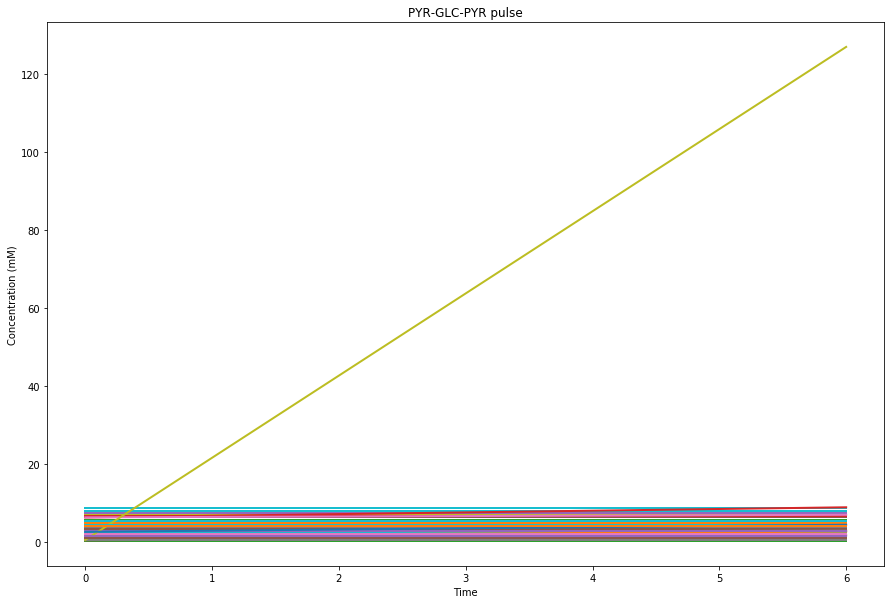

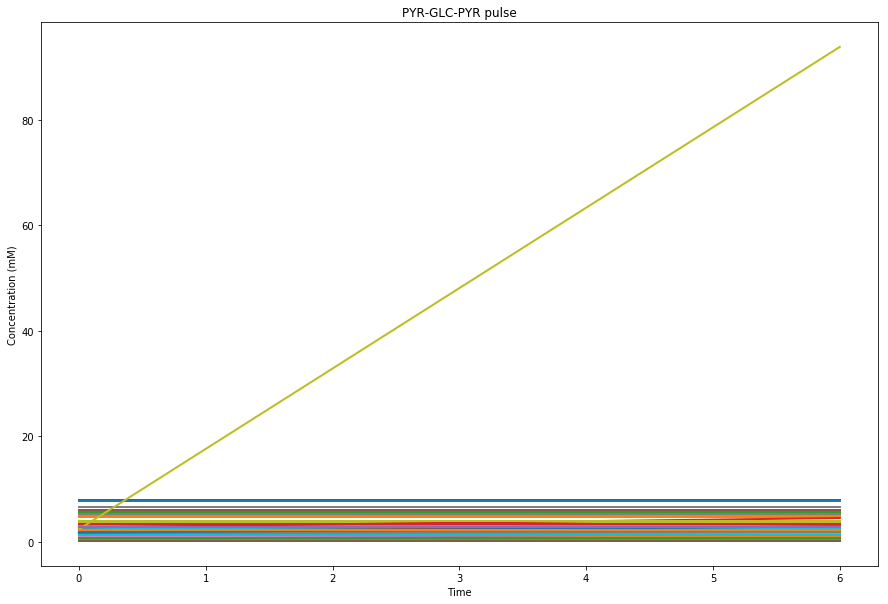

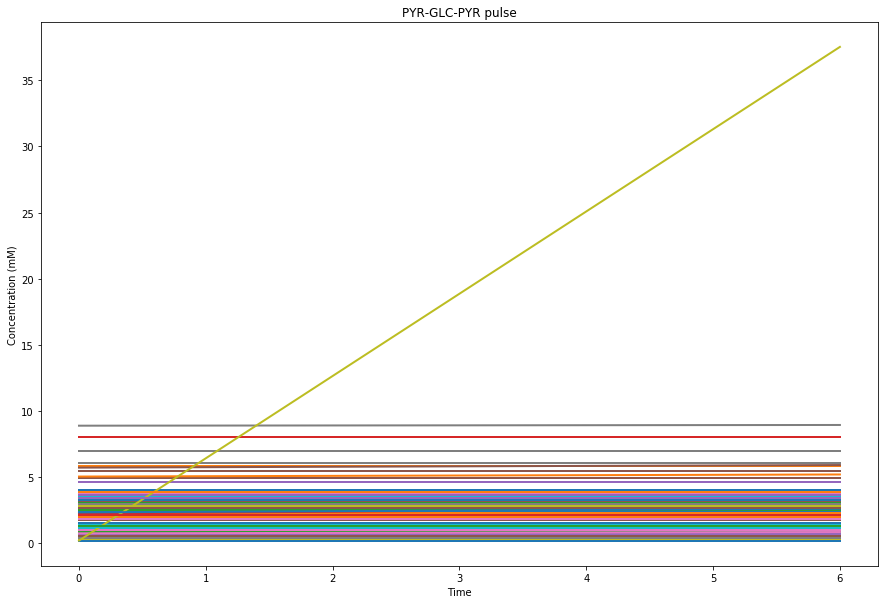

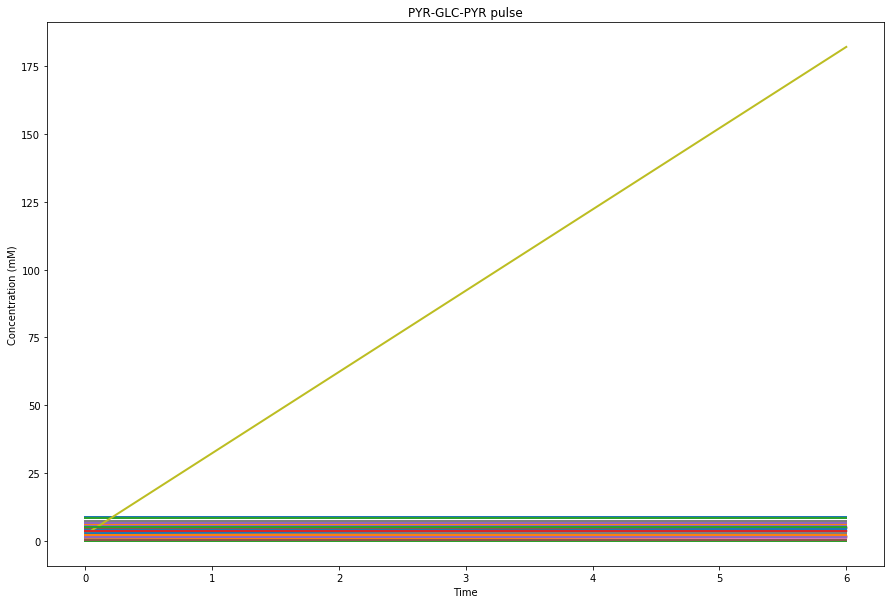

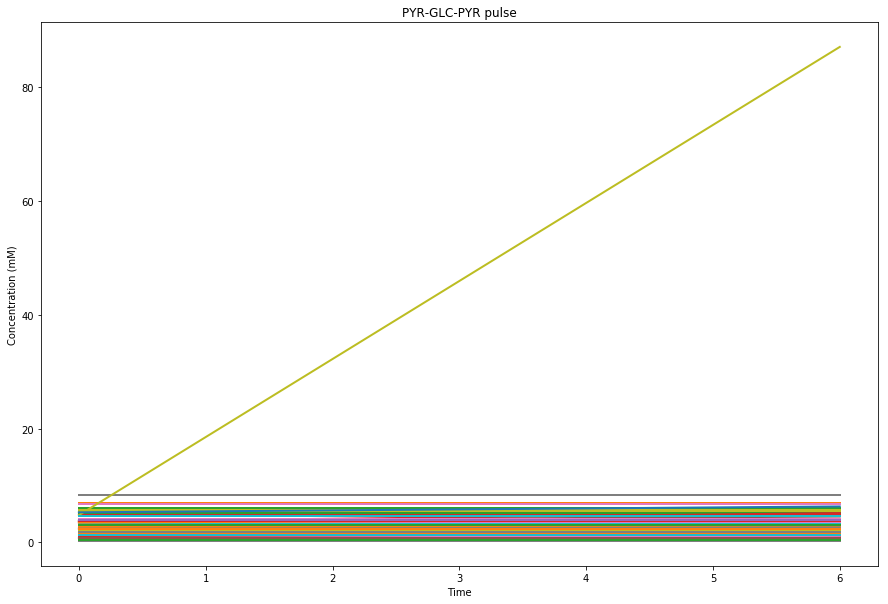

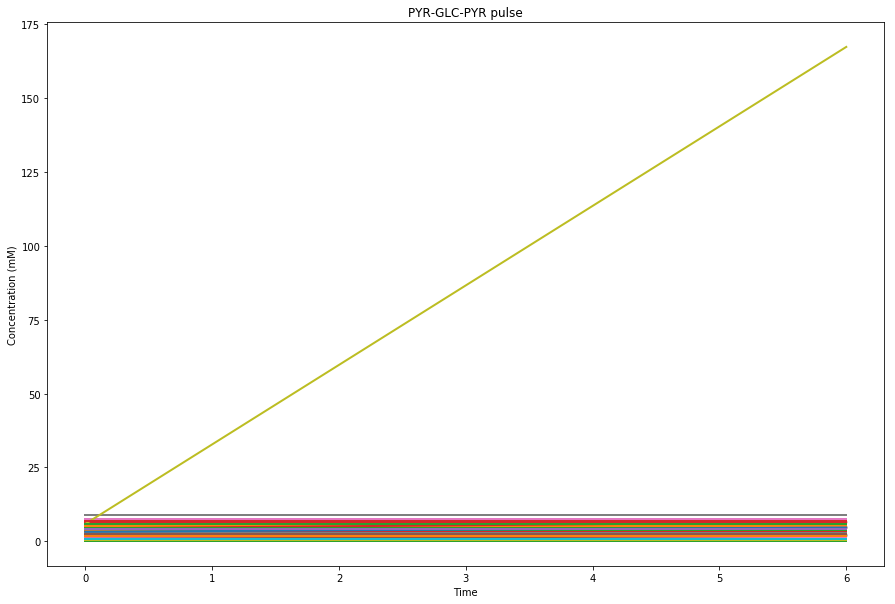

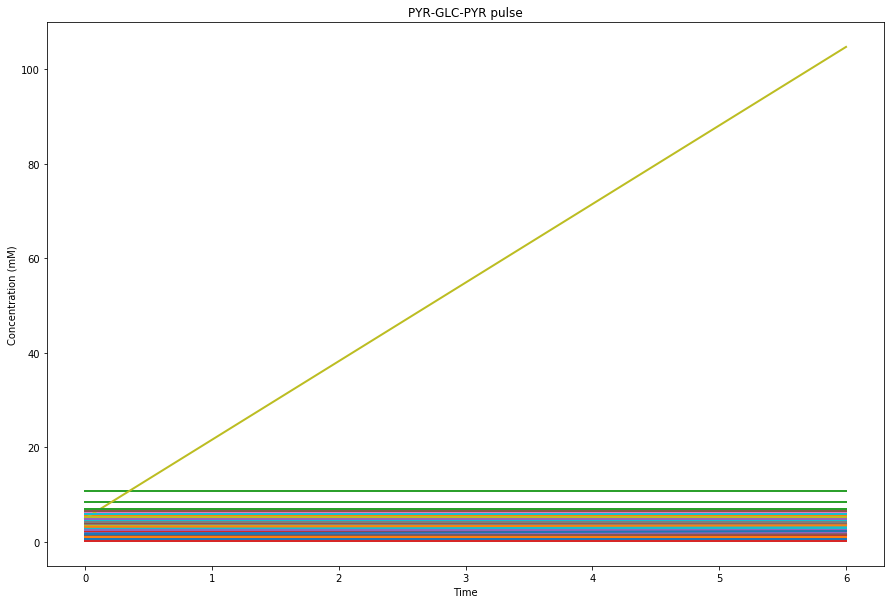

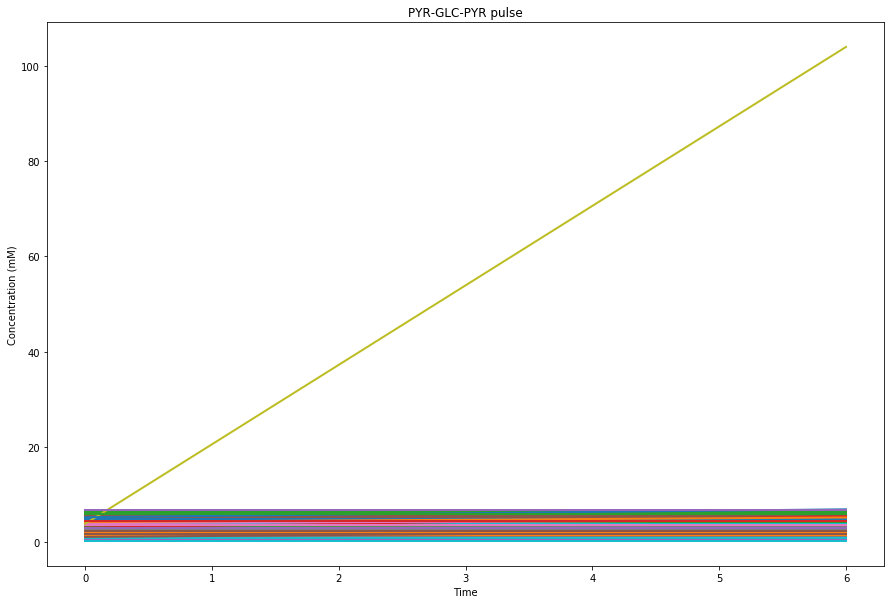

In [14]:
sim_datas = []
for condition in settings.CONDITIONS:
    string_model = parameterize(string_model,condition)
    antimony_model = to_antimony(string_model, exchange=exchange) 
    r = te.loada(antimony_model) 
    r.timeCourseSelections= ['time'] + r.getBoundarySpeciesIds() + r.getFloatingSpeciesIds()
    sim_data = r.simulate(0,6,100)
    sim_datas += [sim_data]
    met_labels = [mapping[x] if x in mapping else x for x in sim_data.colnames]
    fig = plt.figure(figsize=(15,10))
    te.plotArray(sim_data, ylabel='Concentration (mM)', xlabel='Time',
                 title='Steady State ?', labels=None)

# Steady-state simulation?
Things needs to be in steady-state, but not everything is. So what is going on here? We need to fix this. That might mean going back all the way to the drawing board (demarcate.py). Remember that it is risky to remove things from the dynamic model and not start at the stoichiometry, because the fluxes are derived from the stoichiometry. The challenge is to get to the steady-state simulation.

Realize that if one thing is not in steady-state, it could affect another and cause that to be out of steady-state, so the cause of imbalance (non-steady state flux simulation) can be upstream. Having a proper demarcation should resolve this.

Note: small deviations from t0 till t_end might occur as a numerical issue (e.g. effect of rounding in the flux solution. These deviations are minimal though, but important to consider. See what happens when you change the tolerance below.

In [16]:
unbalanced = []
tolerance = .001 
for i, sim_data in enumerate(sim_datas):
    l=[]
    print('\n'+settings.CONDITIONS[i])
    for x in sim_data.colnames[1:]:
        if not abs(sim_data[x][0] - sim_data[x][-1]) < tolerance:
            l += [mapping[x]]
            print(mapping[x], sim_data[x][0], sim_data[x][-1])
    unbalanced += [l]

def intersection(unbalanced):
    return set(unbalanced[1]).intersection(*unbalanced)
intersection(unbalanced)


Glucose
pep_c 6.19113883847 8.81427210348
g3p_c 6.23329148781 6.88515854847
f6p_c 2.44821769266 2.80649191437
g6p_c 1.536114232 2.57202700281
gln__L_c 0.309280453354 1.6013921387
o2_c 0.422067584197 127.081166743
e4p_c 2.50439915118 4.32861627441

Gluconate
pep_c 2.76066823164 4.52967559215
g3p_c 1.03832433839 1.47793510608
f6p_c 1.66375024292 1.90536577338
g6p_c 0.439829995466 1.13843625419
gln__L_c 2.07005644764 2.94143996158
o2_c 2.38738685194 93.7949139473
e4p_c 1.72824622602 2.95847480846

Galactose
pep_c 2.20682203389 2.60466491695
g3p_c 0.704670928311 0.803537682144
f6p_c 8.85589477405 8.91023316821
g6p_c 5.00421559172 5.16132942533
gln__L_c 5.67960985086 5.87558061795
o2_c 0.157330025953 37.5403688101
e4p_c 2.29087663126 2.5675502602

Pyruvate
pep_c 2.54099271629 5.1705358739
g3p_c 0.672754994553 1.32621495859
f6p_c 1.50479654819 1.86394624935
g6p_c 0.700586612993 1.73903074189
gln__L_c 2.52562387083 3.82089296234
o2_c 2.57830668667 181.863651152
e4p_c 3.00988171311 4.83855649

{'e4p_c', 'f6p_c', 'g3p_c', 'g6p_c', 'gln__L_c', 'o2_c', 'pep_c'}